# Fashion mnist notebook

* The fashion mnist data consists of 70,000 images divided into 60,000 training and 10,000 testing samples. Dataset sample consists of 28x28 grayscale image, associated with a label from 10 classes that represents the article of clothing . This is a multiclass classification problem.


* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.


* In this notebook we will try to predict which label the images belongs to. (The labels will comes next), by using dimensionality reduction (there are 784 dimensions) and more.

### Import necessary libraries

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
# models part
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import metrics
import xgboost
from sklearn.ensemble import StackingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
# warnings
import warnings
warnings.filterwarnings('ignore')

### Import the data

In [2]:
df_train=pd.read_csv("C:/Users/97254/.conda/fashion-mnist_train.csv")
df_test=pd.read_csv("C:/Users/97254/.conda/fashion-mnist_test.csv")

In [3]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(60000, 785)

#### There are 785 columns, each columm is one pixel, so there are 784 pixels as we said (the 'label' column is our target )

### Labels

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

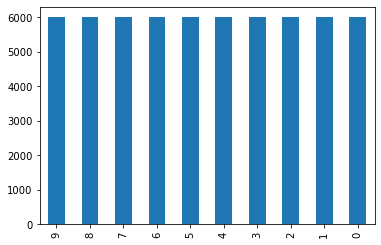

In [5]:
df_train.label.value_counts().plot(kind='bar')

* So there are 10 labels, and 60000 samples. each one of the labels has 6000 samples. 

#### Short visualization of the data

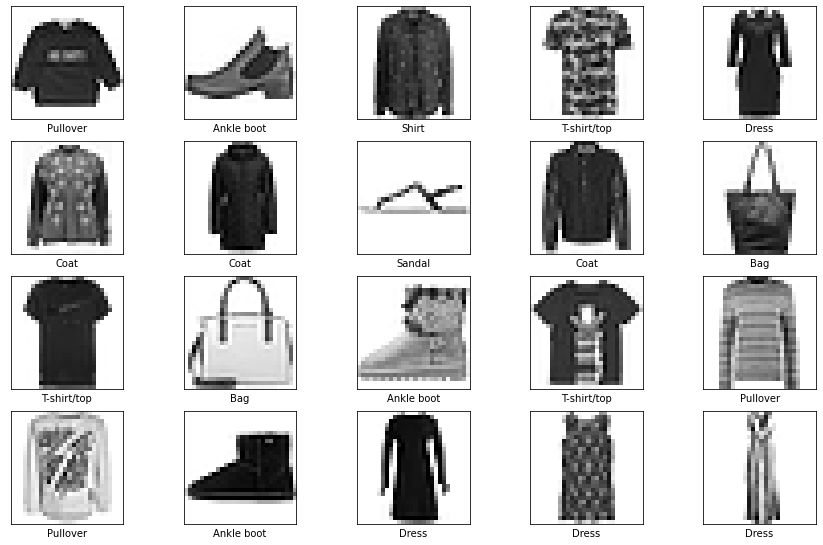

In [6]:
label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
target = df_train[['label']].iloc[:, :]
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(df_train.drop(['label'],axis=1).iloc[i, :]).reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(label[target.label.iloc[i]])

# PCA

### Choosing the right number of Dimensions

####  First, i will split the data into train-test (without dimensionality reduction)

In [133]:
y = df_train['label'] 
X = df_train.drop(['label'], axis=1).to_numpy() 

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=42)

#### Now, let's computes the number of dimensions (approximatly) required to reach high percentages of the training set’s variance (I want to take minimun number of dimensions so the model will be compressed)


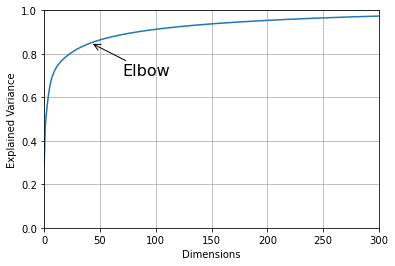

In [8]:
pca = PCA()
pca.fit(X_train)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.axis([0, 300, 0, 1])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.annotate("Elbow", xy=(42, 0.85), xytext=(70, 0.7),arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)


* 'elbow' shows where the explained variance stops growing fast

**We can see that even a before 50 dimensions the explained variance stops growing fast! and if i take even 100 dimensions i wouldn't lose too much explained variance**

**It means i can take even only about 50 dimensions instead of 784 dimensions, most of the variance is preserved, and my data will be less than 10% from the original size!**

### Now let's check how many important features has with random forrest classifier

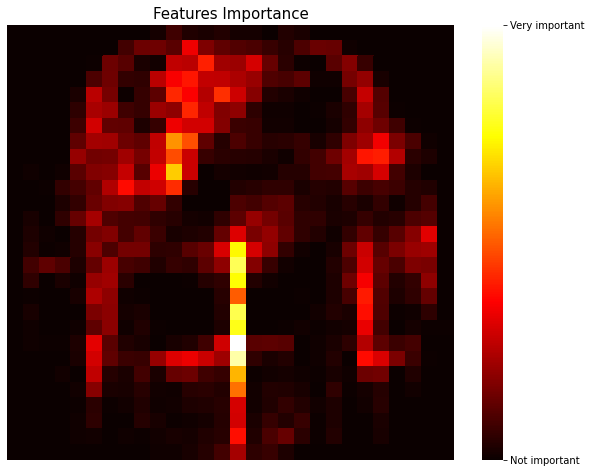

In [9]:
model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
model.fit(X_train, y_train)

importances = model.feature_importances_
pixels = np.reshape(importances,(28,28))

plt.figure(figsize= (10,8))
plot = sns.heatmap(pixels,cmap=plt.cm.hot)
plt.xticks([], [])
plot.set_yticks([])
plot.set_yticks([], minor=True)
colorbar = plot.collections[0].colorbar
colorbar.set_ticks([0,max(importances)])
colorbar.set_ticklabels(['Not important','Very important'])
plt.title('Features Importance',size = 15)
plt.show()

**Also here, we can see that most of the features are not important, we actually don't need them to the prediction**

### So i decided to take only 25 features instead of 784

**Fashion mnist with 25 dimensions**

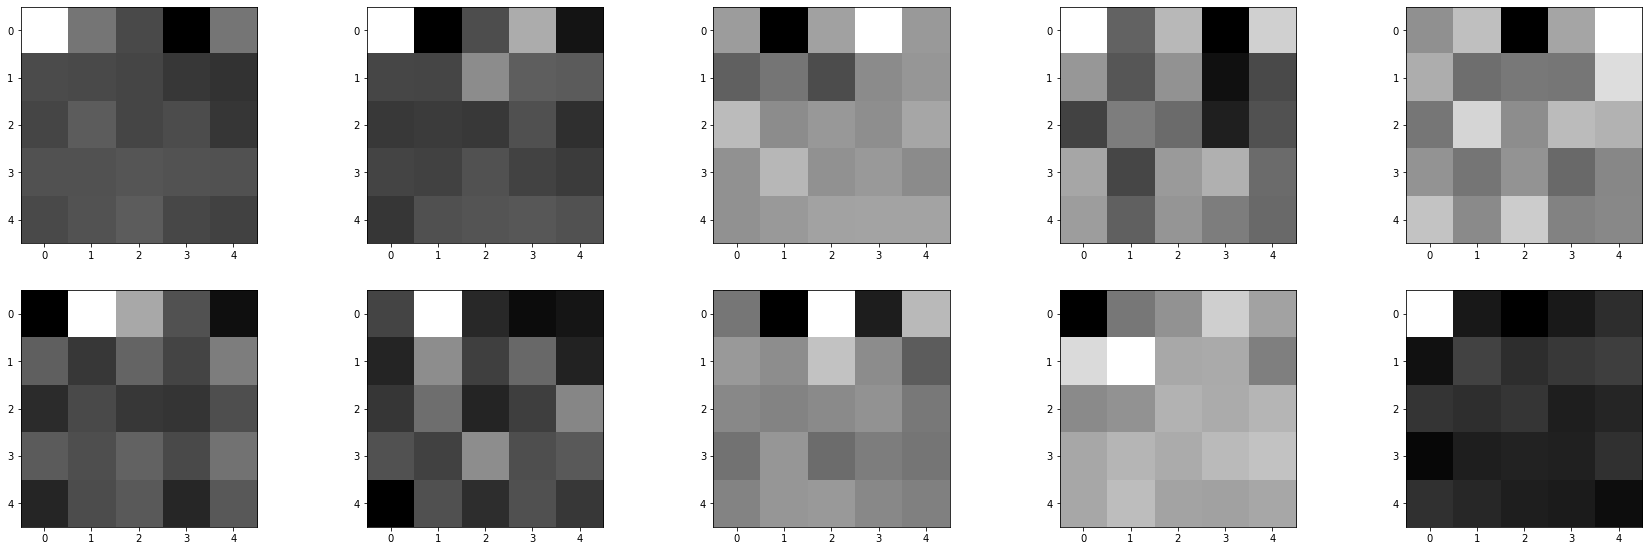

In [10]:
pca = PCA(n_components=25)
X_reduced = pca.fit_transform(X_train)

plt.figure(figsize=(30,20))
for i in range(10):
    plt.subplot(4,5,i+1)
    plt.imshow(X_reduced[i].reshape(5,5), cmap="gist_yarg")
    plt.grid(False)



## Modeing

* First, i simply chhose some models with parameters and check their score on the validation set
* second, i checked the best parameters for the models using GridSearchCv
* Third, evaluate on the validation set
* Fourth, check the score on 100 dimensions and see what is better
* Finally, after finishing train the models on the validation set, i will take the best models and check them on the test set

In [134]:
# split the test set
X_test=df_test.drop(['label'], axis = 1)
y_test=df_test['label']

In [135]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
#transform also the test set
X_test=scaler.transform(X_test)

In [136]:
# 25 dimensions
pca = PCA(n_components=25)
X_train_reduced = pca.fit_transform(X_train)
X_val_red=pca.transform(X_val)
#transform also the test set
X_test_red=pca.transform(X_test)

In [138]:
def result(model):
#     res= pipe(model)
    model.fit(X_train_reduced, y_train)
    y_predict = model.predict(X_val_red)
    print(round(metrics.accuracy_score(y_val,y_predict)*100,4),"%")

### KNN

In [139]:
knn = KNeighborsClassifier(n_neighbors = 5)
result(knn)

84.0917 %


### Random forrest

In [100]:
rfc=RandomForestClassifier()
result(rfc)

85.3083 %


### AdaBoost

In [19]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,algorithm="SAMME.R", learning_rate=0.5)
result(ada)

51.4583 %


### XGboost

In [101]:
xgbc=xgb.XGBClassifier(n_estimators=50,use_label_encoder=False,eval_metric='mlogloss')
result(xgbc)

85.1333 %


### grid search
* First, train the models on the training set and check the best parameters for some models using GridSearchCv
* Then, evaluate on the validation set
* Finally, after finishing train the models on the validation set, check them one time on the test set

### KNN

In [27]:
## Fit on the reduced train set
param_grid_knn=[{'n_neighbors': [5,7,10,15,17],'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
model=KNeighborsClassifier()
grid_search_knn=GridSearchCV(model,param_grid_knn,cv=2,scoring='accuracy')
grid_search_knn.fit(X_train_reduced, y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'n_neighbors': [5, 7, 10, 15, 17]}],
             scoring='accuracy')

In [28]:
## Best params
grid_knn=grid_search_knn.best_params_
grid_knn

{'algorithm': 'auto', 'n_neighbors': 10}

In [29]:
## Evaluate with the best parameters on the reduced test set
knn_res=grid_search_knn.best_estimator_
print(round(knn_res.score(X_val_red,y_val)*100,4),"%")

84.3417 %


#### The improvement is very neglectible

### Random forrest

In [106]:
## Fit on the reduced train set
param_grid_rf=[{'n_estimators':[100,150,175,200,225],'max_depth':[5,7,12,15,18,21]}]
model=RandomForestClassifier()
grid=GridSearchCV(model,param_grid_rf,cv=2,scoring='accuracy')
grid.fit(X_train_reduced, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5, 7, 12, 15, 18, 21],
                          'n_estimators': [100, 150, 175, 200, 225]}],
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

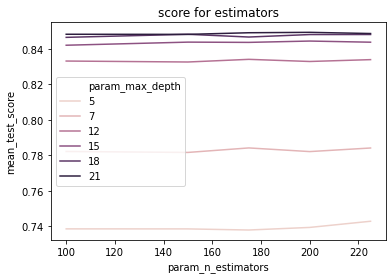

In [107]:
cv_res=pd.DataFrame(grid.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend='full',hue='param_max_depth')
plt.title('score for estimators')

In [108]:
## Best params
grid.best_params_

{'max_depth': 21, 'n_estimators': 200}

In [109]:
## Evaluate with the best parameters on the reduced test set
rf_res=grid.best_estimator_
print(round(rf_res.score(X_val_red,y_val)*100,4),"%")

85.5167 %


#### The improvement is very neglectible

### AdaBoost

In [45]:
## Fit on the reduced train set
param_grid_ada=[{'n_estimators':[50,75,100,125,150],'learning_rate':[0.2,0.5,1,1.5,2]}]
model=AdaBoostClassifier(n_estimators=50,random_state=10)
grid_search_ada=GridSearchCV(model,param_grid_ada,cv=2,scoring='accuracy')
grid_search_ada.fit(X_train_reduced, y_train)

GridSearchCV(cv=2, estimator=AdaBoostClassifier(random_state=10),
             param_grid=[{'learning_rate': [0.2, 0.5, 1, 1.5, 2],
                          'n_estimators': [50, 75, 100, 125, 150]}],
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

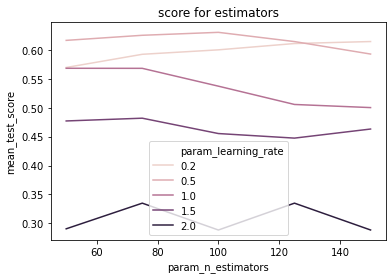

In [46]:
cv_res=pd.DataFrame(grid_search_ada.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend='full',hue='param_learning_rate')
plt.title('score for estimators')

In [47]:
## Best params
grid_search_ada.best_params_

{'learning_rate': 0.5, 'n_estimators': 100}

In [48]:
## Evaluate with the best parameters on the reduced test set
ada_res=grid_search_ada.best_estimator_
print(round(ada_res.score(X_val_red,y_val)*100,4),"%")

60.6583 %


#### The improvement is by 9%, but adaboost here is very low compare to other models

### XGboost

In [110]:
## Fit on the reduced train set
param_grid_xg=[{'n_estimators':[140,165,190,215,240],'learning_rate':[0.2,0.5,1,1.5]}]
model=xgb.XGBClassifier(eval_metric='mlogloss')
grid_search_xg=GridSearchCV(model,param_grid_xg,cv=2,scoring='accuracy')
grid_search_xg.fit(X_train_reduced, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

Text(0.5, 1.0, 'score for estimators')

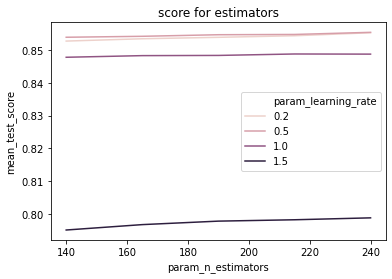

In [111]:
cv_res=pd.DataFrame(grid_search_xg.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend='full',hue='param_learning_rate')
plt.title('score for estimators')

In [112]:
grid_search_xg.best_params_

{'learning_rate': 0.5, 'n_estimators': 240}

In [113]:
xg_res=grid_search_xg.best_estimator_
print(round(xg_res.score(X_val_red,y_val)*100,4),"%")

86.35 %


**Improvement by more than 1%**

### Voting

#### now let's take the best params of the models and use it inside voting

In [119]:
voting_ = VotingClassifier(([('xgb',xg_res),('rfc',rf_res),('knn',knn_res)]),voting='hard')
voting_.fit(X_train_reduced,y_train)
print(round(voting_.score(X_val_red,y_val)*100,4),"%")

86.0667 %


In [121]:
voting_ = VotingClassifier(([('xgb',xg_res),('rfc',rf_res),('knn',knn_res)]),voting='soft',weights=[2,2,1])
voting_.fit(X_train_reduced,y_train)
print(round(voting_.score(X_val_red,y_val)*100,4),"%")

86.4417 %


### Stacking

#### now let's take the best params of the models and use it inside voting

In [120]:
stack=StackingClassifier([('xgb',xg_res),('rfc',rf_res),('knn',knn_res)])
stack.fit(X_train_reduced,y_train)
print(round(stack.score(X_val_red,y_val)*100,4),"%")

86.3667 %


### Kmeans

In [170]:
pipeline = Pipeline([("kmeans", KMeans(n_clusters=50)),
("log_reg", LogisticRegression()),
])
pipeline.fit(X_train_reduced, y_train)

param_grid = dict(kmeans__n_clusters=range(10, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=2, verbose=2)
grid_clf.fit(X_train_reduced, y_train)
grid_clf.best_params_
grid_clf.score(X_val_red, y_val)

Fitting 2 folds for each of 90 candidates, totalling 180 fits
[CV] kmeans__n_clusters=10 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ kmeans__n_clusters=10, total=   5.4s
[CV] kmeans__n_clusters=10 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ............................ kmeans__n_clusters=10, total=   5.2s
[CV] kmeans__n_clusters=11 ...........................................
[CV] ............................ kmeans__n_clusters=11, total=   5.4s
[CV] kmeans__n_clusters=11 ...........................................
[CV] ............................ kmeans__n_clusters=11, total=   5.4s
[CV] kmeans__n_clusters=12 ...........................................
[CV] ............................ kmeans__n_clusters=12, total=   5.6s
[CV] kmeans__n_clusters=12 ...........................................
[CV] ............................ kmeans__n_clusters=12, total=   5.8s
[CV] kmeans__n_clusters=13 ...........................................
[CV] ............................ kmeans__n_clusters=13, total=   6.1s
[CV] kmeans__n_clusters=13 ...........................................
[CV] ............................ kmeans__n_clusters=13, total=   5.9s
[CV] kmeans__n_clusters=14 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 50.8min finished


0.7560833333333333

In [172]:
xg_km=grid_clf.best_estimator_
xg_km.score(X_val_red, y_val)

0.7560833333333333

### What is the difference if i take 100 dimensions?

In [159]:
def pipe100(model):
    pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components=100)),('model', model)])
    return pipe

In [160]:
def result100(model):
    res= pipe100(model)
    res.fit(X_train, y_train)
    y_predict = res.predict(X_val)
    print(round(metrics.accuracy_score(y_val,y_predict)*100,4),"%")

In [169]:
xgbc = XGBClassifier(eval_metric='mlogloss', learning_rate = 0.5, n_estimators= 240)
result100(xgbc)

88.4 %


* The difference is 2%, so i prefered to took 25 dimensions and not more than that

## Subtotal

In [179]:
data = {'knn':  ['84.34%'],
        'Random Forest': ['85.51%'],
        'voting': ['86.44%'],
        'AdaBoost':['60.35%'],
        'xgboost':['86.35%'],
        'stacking':['86.36%'],
        'Kmeans':['75.68']
        }
df = pd.DataFrame (data, columns = ['knn','Random Forest','AdaBoost','xgboost','voting','stacking','Kmeans']
                   ,index=['accuracy'])
df

,knn,Random Forest,AdaBoost,xgboost,voting,stacking,Kmeans
accuracy,84.34%,85.51%,60.35%,86.35%,86.44%,86.36%,75.68


## After dimensionality reduction to 25 using pca, the best score on the validation set is voting with 86.44%, and Xgboost and stacking has only 0.10% less

### result on the test set

* i will take the 3 models and see the score on the test set. i will do it one time and this is the final result

In [144]:
def res_test(model):
    model.fit(X_train_reduced, y_train)
    print(round(model.score(X_test_red,y_test)*100,4),"%")

### Xgboost

In [147]:
xgb = XGBClassifier(eval_metric='mlogloss', learning_rate = 0.5, n_estimators= 240)
res_test(xgb)

86.38 %


              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.98      0.97      0.97      1000
           2       0.80      0.77      0.79      1000
           3       0.88      0.88      0.88      1000
           4       0.78      0.82      0.80      1000
           5       0.93      0.92      0.92      1000
           6       0.67      0.63      0.65      1000
           7       0.91      0.91      0.91      1000
           8       0.97      0.98      0.97      1000
           9       0.91      0.94      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



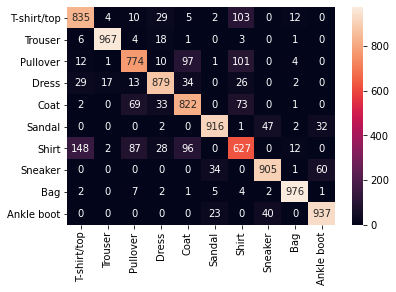

In [178]:
# confusion matrix
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred=xgb.predict(X_test_red)
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(pd.DataFrame(cm),annot=True,fmt="d",xticklabels=labels,yticklabels=labels) 
print(classification_report(y_test,y_pred))
plt.show()

### Voting

In [152]:
voting = VotingClassifier(estimators=[('knn', knn), ('rfc', rfc), ('xgb', xgbc)],voting='soft' ,weights=[2,2,1])
res_test(voting)

86.03 %


              precision    recall  f1-score   support

           0       0.61      0.80      0.69      1000
           1       0.97      0.84      0.90      1000
           2       0.53      0.70      0.60      1000
           3       0.83      0.55      0.66      1000
           4       0.50      0.62      0.55      1000
           5       0.00      0.00      0.00      1000
           6       0.38      0.20      0.26      1000
           7       0.05      0.00      0.01      1000
           8       0.29      0.90      0.44      1000
           9       0.63      0.61      0.62      1000

    accuracy                           0.52     10000
   macro avg       0.48      0.52      0.48     10000
weighted avg       0.48      0.52      0.48     10000



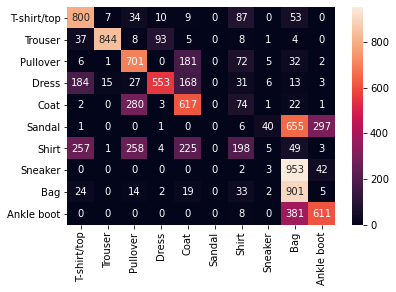

In [176]:
# confusion matrix
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred=voting.predict(X_reduced_tes)
cm=confusion_matrix(y_tests,y_pred)
sns.heatmap(pd.DataFrame(cm),annot=True,fmt="d",xticklabels=labels,yticklabels=labels) 
print(classification_report(y_test,y_pred))
plt.show()

### Stacking

In [151]:
stack=StackingClassifier([('xgb',xg_res),('rfc',rf_res),('knn',knn_res)])
stack.fit(X_train_reduced,y_train)
print(round(stack.score(X_test_red,y_test)*100,4),"%")

86.61 %


              precision    recall  f1-score   support

           0       0.62      0.79      0.69      1000
           1       0.97      0.89      0.93      1000
           2       0.45      0.74      0.56      1000
           3       0.84      0.70      0.77      1000
           4       0.53      0.23      0.32      1000
           5       0.85      0.02      0.04      1000
           6       0.38      0.23      0.28      1000
           7       0.25      0.00      0.01      1000
           8       0.27      0.90      0.42      1000
           9       0.61      0.55      0.58      1000

    accuracy                           0.51     10000
   macro avg       0.58      0.51      0.46     10000
weighted avg       0.58      0.51      0.46     10000



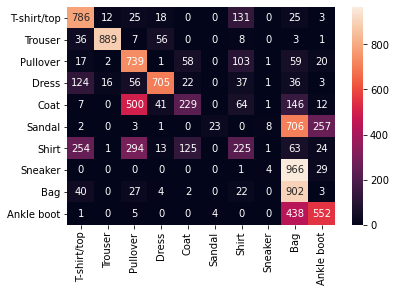

In [177]:
# confusion matrix
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred=stack.predict(X_reduced_tes)
cm=confusion_matrix(y_tests,y_pred)
sns.heatmap(pd.DataFrame(cm),annot=True,fmt="d",xticklabels=labels,yticklabels=labels) 
print(classification_report(y_test,y_pred))
plt.show()

### Summary

In [180]:
data_res = {'voting': ['86.03%'],
        'xgboost':['86.38%'],
        'stacking':['86.61%'],
        }
df_res = pd.DataFrame (data_res, columns = ['xgboost','voting','stacking']
                   ,index=['accuracy'])
df_res

,xgboost,voting,stacking
accuracy,86.38%,86.03%,86.61%


## Final result: the best result is stacking with 86.61%, after dimensionality reduction to 25 using pca 